In [1]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.integrate._bvp import BVPResult
from matplotlib import pyplot as plt

from typing import List, Tuple, Callable, Optional

from matplotlib import animation

from scipy.special import ellipe
from operator import itemgetter

# Abstract
We find the optimal path and control of navigating from one planet to another planet by using the laws of gravity to help with 
the acceleration. This is done by using Pontryagin maximum principle, and we discovered sensitivity in our system when optimizing over $t_f$ and found a solution to numerical instabilty when 
adding massive planets such as the sun. 

# Background
The Dune Guild Naviators are tasked with delivering House Atreides from the planet Caladan to Arrakis. Usually they solve the optimal control in their mind while taking spice, but since spice production
has been disrupted, they've instead decided to turn to ACME students on Earth to solve the optimal control for them. They have asked the ACME students to find the best path that minimizes both fuel consumption and time. 

# Mathematical Representation
Since planetary orbits are essentially planar, we simplified the problem by only working in two dimensions. The only elements that affect the ship's motion are the forces of gravity between it and the planets in the system, and its own acceleration control. Newton's Law of Universal Gravitation states that the force of gravity applied on body $2$, exerted by body $1$, is given as follows, where $G$ is the gravitational constant.

$\mathbf{F}_{21} = -G\frac{m_1m_2}{||\mathbf{x}_2-\mathbf{x}_1||_2^3}(\mathbf{x}_2-\mathbf{x}_1)$

We used this equation and Newton's second law of motion, $F=ma$, to solve for the acceleration of the ship due to the gravity applied by a given planet. The net acceleration is given by the sum of the accelerations from all planets in the system, combined with the acceleration due to the ship's control. This defines the state equations, where $m_p$ is the mass of the planet, $\mathbf{x}_s$ is the position vector of the spaceship, $\mathbf{x}_p$ is the position vector of the given planet, and $\mathbf{u}$ is the acceleration control vector of the spaceship. The set of all $n$ planets in the system is given as $P = \{p_1, p_2,\dots,p_n\}$ where $p_1$ is the planet Caladan, and $p_n$ is the planet Arrakis.

$\ddot{\mathbf{x}} = -G\sum_{p\in{P}}^{}\frac{m_p}{||\mathbf{x}_s-\mathbf{x}_p||_2^3}(\mathbf{x}_s-\mathbf{x}_p) + \mathbf{u}$

Converting $\ddot{\mathbf{x}}$ into a first order system of equations produces the following state equations. 

$\begin{pmatrix}
    \dot{x}_s \\
    \dot{y}_s \\
    \ddot{x}_s\\
    \ddot{y}_s 
\end{pmatrix} = \begin{pmatrix}
    \dot{x}_s \\
    \dot{y}_s \\
    -G\sum_{p\in{P}}^{}\frac{m_p(x_s - x_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + u_x \\
    -G\sum_{p\in{P}}^{}\frac{m_p(y_s - y_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + u_y
\end{pmatrix}$

The cost functional is defined to minimize the total fuel usage by minimizing the squared magnitude of the control. 

$J[u] = \int_{t_0}^{t_f}||\mathbf{u}||_2^2dt$

In order to properly take off and land, the ship must match both the position and velocity of the planet. This gives the following boundary conditions. 

$\mathbf{x}_s(t_0) = \text{Caladan's Position},\: \dot{\mathbf{x}}_s(t_0) = \text{Caladan's Velocity}$

$\mathbf{x}_s(t_f) = \text{Arrakis' Position},\: \dot{\mathbf{x}}_s(t_f) = \text{Arrakis' Velocity}$

We used the cost functional and state equations to variously solve the folowing scenarios:

$\underset{u}{min}$ $J[u]$, $\underset{u,t_0}{min}$ $J[u]$, $\underset{u,t_f}{min}$ $J[u]$, and $\underset{u,t_0,t_f}{min}$ $J[u].$

# Solution
Pontryagin maximum principle tells us that:

$H = \mathbf{p}\cdot\mathbf{f(\mathbf{x})} - L$

$\mathbf{p}' = -\frac{DH}{D\mathbf{x}}$ and

$\frac{DH}{D\tilde{\mathbf{u}}} = 0.$

Applying this to our state equation and Lagrangian yields the following Hamiltonian:

$H = p_1\dot{x}_s + p_2\dot{y}_s + p_3\left[-G\sum_{p\in{P}}^{}\frac{m_p(x_s - x_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + u_x\right] + p_4\left[ -G\sum_{p\in{P}}^{}\frac{m_p(y_s - y_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + u_y\right] - u_x^2 - u_y^2.$

This give us the following co-state evolution equations:

$\dot{p}_1 = p_3G\left(\sum_{p\in{P}}^{}\frac{m_p}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} - \frac{3m_p(x_s - x_p)^2}{((x_s-x_p)^2+(y_s-y_p)^2)^{5/2}}\right)$

$\dot{p}_2 = p_4G\left(\sum_{p\in{P}}^{}\frac{m_p}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} - \frac{3m_p(y_s - y_p)^2}{((x_s-x_p)^2+(y_s-y_p)^2)^{5/2}}\right)$

$\dot{p}_3 = -p_1 $

$\dot{p}_4 = -p_2. $

Since the states $\mathbf{x}_i$ all have fixed boundary conditions, the costates $\mathbf{p}_i$ are all free at the boundaries.

Now we the control $\tilde{\mathbf{u}}$ that maximizes the Hamiltonian:

$\frac{\partial H}{\partial u_x} = p_3 - 2u_x = 0$

$\frac{\partial H}{\partial u_y} = p_4 - 2u_y = 0$

[comment]:<$\frac{\partial H}{\partial u_x} = p_3 - 2u_x \:\:\text{and}\:\: \frac{\partial H}{\partial u_y} = p_4 - 2u_y$>

Solving for $u_x$ and $u_y$ yields the optimal control:

$\tilde{u}_x = \frac{p_3}{2}$

$\tilde{u}_y = \frac{p_4}{2}.$

[comment]:<$\tilde{u}_x = \frac{p_3}{2} \:\:\text{and}\:\: \tilde{u}_y = \frac{p_4}{2}.$>

Plugging $\tilde{u}_x$ and $\tilde{u}_y$ back into the state and costate evolution equations defines the following boundary value problem.

$\dot{x}_s = \dot{x}_s$

$\dot{y}_s = \dot{y}_s$

$\ddot{x}_s = -G\sum_{p\in{P}}^{}\frac{m_p(x_s - x_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + \frac{p_3}{2}$

$\ddot{y}_s = -G\sum_{p\in{P}}^{}\frac{m_p(y_s - y_p)}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} + \frac{p_4}{2}$

$\dot{p}_1 = p_3G\left(\sum_{p\in{P}}^{}\frac{m_p}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} - \frac{3m_p(x_s - x_p)^2}{((x_s-x_p)^2+(y_s-y_p)^2)^{5/2}}\right)$

$\dot{p}_2 = p_4G\left(\sum_{p\in{P}}^{}\frac{m_p}{((x_s-x_p)^2+(y_s-y_p)^2)^{3/2}} - \frac{3m_p(y_s - y_p)^2}{((x_s-x_p)^2+(y_s-y_p)^2)^{5/2}}\right)$

$\dot{p}_3 = -p_1$

$\dot{p}_4 = -p_2.$


With boundary conditions

$x_s(t_0) = x_{p_1}(t_0),\:y_s = y_{p_1}(t_0),\:\dot{x}_s(t_0) = \dot{x}_{p_1}(t_0),\:\dot{y}_s(t_0) = \dot{y}_{p_1}(t_0)$

and 

$x_s(t_f) = x_{p_2}(t_f),\:y_s = y_{p_2}(t_f),\:\dot{x}_s(t_f) = \dot{x}_{p_2}(t_f),\:\dot{y}_s(t_f) = \dot{y}_{p_2}(t_f)$

if we are optimizing over $t_f$ we get the added boundary condition that $H(t_f) = 0$, and if we are optimizing over $t_0$ we get $H(t_0)=0$. This problem is now set up to use `solve_bvp`.


In [2]:
# Globals
YEAR_TO_SEC = 31536000

In [4]:
class Planet:
    """Model an orbitting & offset planet."""
    
    
    def __init__(
        self,
        name: str,
        mass: float,
        R: Optional[Tuple[float, float]],
        velocity: float,
        radius: float = 0,
        t0_years: float = 0,
        offset: Optional[Tuple[float, float]] = None
    ):
        """Create a planet.

        Args:
            name (str): The name.
            mass (float): Mass in KG.
            R (Optional[Tuple[float, float]]): Major and minor radii lengths in KM, or None for no orbitting.
            velocity (float): Speed in m/s of orbit.
            radius (float, optional): Planetary radius in meters. Defaults to 0.
            t0_years (float, optional): initial time offset along orbit, IN YEARS. Defaults to 0.
            offset (Optional[Tuple[float, float]], optional): X and Y offset 
                to orbit center, or None for centered at origin. Defaults to None.
        """
            
        #Initialize parameters
        self.mass = mass
        self.t0_years = t0_years
        self.R = R
        if R is not None:
            self.R1 = R[0]
            self.R2 = R[1]
        self.velocity = velocity
        self.name = name
        self.radius = radius
        
        
        if self.R is not None:

            # calculate the circumference of the ellipse using scipy special ellipse integral
            eccentricity_squared = 1-(self.R2**2)/(self.R1**2)
            Circumference = 4*self.R1*ellipe(eccentricity_squared)
            
            #calculate angular velocity given circumference of orbit, velocity:
            # (m/s)/m = /s, /s *2*pi = radians/s = ω, angular frequency/velocity
            # So we need 2π*velocity/circumference
            self.omega = 2*np.pi*velocity/Circumference #omega is in units of radians/second
            
        self.offset = offset
    
    def px(self,t_sec: np.ndarray) -> np.ndarray:
        """Get the planet's x position over time.

        Args:
            t_sec (np.ndarray): time values, in seconds.

        Returns:
            np.ndarray: x position values, in meters.
        """
        t_new = t_sec + self.t0_years*YEAR_TO_SEC 
        return (
            (np.ones_like(t_new)*self.offset[0] if self.offset is not None else np.zeros_like(t_new))
            + (self.R1*np.cos(self.omega*t_new) if self.R is not None else np.zeros_like(t_new))
        )
    
    def py(self,t_sec: np.ndarray) -> np.ndarray:
        """Get the planet's y position over time.

        Args:
            t_sec (np.ndarray): time values, in seconds.

        Returns:
            np.ndarray: y position values in meters.
        """

        t_new = t_sec + self.t0_years*YEAR_TO_SEC
        return (
            (np.ones_like(t_new)*self.offset[1] if self.offset is not None else np.zeros_like(t_new))
            + (self.R2*np.sin(self.omega*t_new) if self.R is not None else np.zeros_like(t_new))
        )
    
    def velocity_vector(self, t_sec: np.ndarray) -> np.ndarray:
        """Get the tangential velocity vector of the planet at a given time.

        Args:
            t_sec (np.ndarray): the times.

        Returns:
            np.ndarray: The X and Y tangential speeds in m/s.
        """

        t_new = t_sec + self.t0_years*YEAR_TO_SEC
        if self.R is not None:
            return self.omega*np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
        else:
            return np.array([np.zeros_like(t_new), np.zeros_like(t_new)])

In [5]:
def animate(
    soln: BVPResult,
    tf: Optional[float],
    t: np.ndarray,
    planets: List[Planet],
    figname: str | None = None,
    animname: str | None = None,
    n_anim_frames: int = 200,
    anim_len_sec: float = 5,
    fig_suptitle: Optional[str] = None
):
    """Animate a system of planets and their trajectories.

    Args:
        soln (BVPResult): solution object of the BVP of the ship's trajectory.
        tf (Optional[float]): final time, used to scale timestep values, or None for no time scaling.
        t (np.ndarray): the time values, in seconds. These may be squished between [0,1] if used in 
            conjunction with a time-parameterized setup, see tf.
        planets (List[Planet]): the planets.
        figname (str | None, optional): Filepath to save figure if given, else don't save a figure. Defaults to None.
        animname (str | None, optional): Filepath to save an animation if given, else don't animate. Defaults to None.
        n_anim_frames (int, optional): Number of frames in the animation. Defaults to 200.
        anim_len_sec (float, optional): Length of animation in seconds. Defaults to 5.
        fig_suptitle (Optional[str], optional): Title of the figure if given, else no title. Defaults to None.
    """
    
    M_TO_KM = 1e-3

    # get the spaceship trajectory & control and convert units.
    sx = soln.sol(t)[0] * M_TO_KM
    sy = soln.sol(t)[1] * M_TO_KM
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    # Create a figure for pictures / animation.
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    # Rescale the displayed sizes of planets based on their masses.
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    
    # For each 
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    # If the final time is given, the times t are relative to this tf. We rescale using this.
    time_scaler = tf if tf is not None else 1
    
    # generate trajectories of the planets and their plots
    for planet in planets:
        
        # Generate planet paths
        pxt = planet.px(t * time_scaler)
        pyt = planet.py(t * time_scaler)
        pxt *= M_TO_KM
        pyt *= M_TO_KM
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        
        # Create plots of planets
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    # Rescale the units of time to be in days.
    t_days = t * time_scaler / YEAR_TO_SEC * 365
    
    # Create graphs for control and speed.
    control_x_graph, = ax2.plot(t_days, ux, label='x accel.')
    control_y_graph, = ax2.plot(t_days, uy, label='y accel.')
    
    
    ship_color = next(ax1._get_lines.prop_cycler)['color']
    
    speed_axis = ax2.twinx()
    speed_axis.set_ylabel("Speed (m/s)")
    speed_plot, = speed_axis.plot(t_days,speed, color=ship_color, label="Speed")
    
    
    # Graph the spaceship
    ss_point, = ax1.plot(sx[-1], sy[-1], "*", color=ship_color, markersize=min_radius)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=ship_color, label='Spaceship')
    
    # Properly label the figures.
    ax1.set(xlabel="x (km)", ylabel="y (km)", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time (Days)", ylabel="Acceleration ($m/s^2$)")

    ax2.legend(loc="upper left", bbox_to_anchor=(1, -0.32, 0.3, 0.3), bbox_transform=ax2.transAxes)
    speed_axis.legend(loc="lower left", bbox_to_anchor=(1, 1, 0.3, 0.3), bbox_transform=speed_axis.transAxes)
    
    # This is for which day it is, only to be used in the animations.
    time_text = ax1.text(0.01, 0.95, "", fontsize=6, transform=ax1.transAxes)
    
    # Add overall title, if given.
    if fig_suptitle is not None:
        fig.suptitle(fig_suptitle, y=-0.04, fontsize=16, fontweight="bold")
    
    fig.tight_layout()
    fig.show()
    
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, bbox_inches="tight", dpi=600)
        print(f"Figure saved to {figname}")



    # Now for each animation frame, we update all the x and y values to be partially filled.
    def update_anim(anim_frame):
        
        # This one-liner scales the index into time to account
        # for the number of animation frames vs the number of 
        # actual timesteps present in the time data.
        i = min(t.shape[0]-1, int((anim_frame+1) / n_anim_frames * t.shape[0]))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets data
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure data
        control_x_graph.set_xdata(t_days[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t_days[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
        speed_plot.set_xdata(t_days[:i+1])
        speed_plot.set_ydata(speed[:i+1])
        
        # Add which day it is onto animation
        time_text.set_text(f"Day {int(t_days[i])}/{int(t_days[-1])}")
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(n_anim_frames), interval=anim_len_sec * 1000 // n_anim_frames)
        anim.save(animname, dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()

def best_path(
    planets: List[Planet],
    T: float,
    n_initial_mesh_nodes: int = 10000,
    max_nodes: int = 30000,
    G: float = 6.674e-11,
) -> Tuple[BVPResult, float, np.ndarray]:
    """Solve the best path and return it as a BVP solution, along with the final time and the time interval.

    Args:
        planets (List[Planet]): Planets in the solver.
        T (float): Final time.
        n_initial_mesh_nodes (int, optional): Initial number of mesh nodes for solver. Defaults to 10000.
        max_nodes (int, optional): Max number of mesh nodes for solver. Defaults to 30000.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.

    Returns:
        Tuple[BVPResult, float, np.ndarray]: Solver result, final time, and the time points to evaluate at.
    """

    # convert the given year time to seconds
    T *= YEAR_TO_SEC
    
    def ode(t: np.ndarray, y: np.ndarray) -> np.ndarray:
        """The eq. for the ODE for use in solve_bvp. The update is computed based on our
        model for Pontryagin's Maximum Principle. 
        """

        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            px_t = planet.px(t)
            py_t = planet.py(t)
            dist = np.linalg.norm(np.array([sx-px_t, sy - py_t]))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t)
            dy = sy - planet.py(t)
            
            # Do these operations in log space for numerical stability.
            ddsx += dx*np.exp(np.log(planet.mass) - np.log(dist3))
            ddsy += dy*np.exp(np.log(planet.mass) - np.log(dist3))
  
            dp1 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dx**2*np.exp(np.log(planet.mass) - np.log(dist5))
            dp2 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dy**2*np.exp(np.log(planet.mass) - np.log(dist5))

        ddsx = -G * ddsx + p3/2
        ddsy = -G * ddsy + p4/2
        
        dp1 = p3*G*dp1
        dp2 = p4*G*dp2
        
        dp3 = -p1
        dp4 = -p2

        return np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    # Position BCs
    # add in the radius of the planet, because we start on the planet's surface
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(T) + planets[1].radius
    target_end_y = planets[1].py(T)
    
    # Velocity BCs
    velocity_start_x, velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x, velocity_end_y = planets[1].velocity_vector(T)
    
    def bc(ya, yb):
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,
            
            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
        ])

    
    t = np.linspace(0, T, n_initial_mesh_nodes)
    y_guess = np.ones((8, t.size))
    y_guess[0:4,0] = [target_start_x, target_start_y, velocity_start_x, velocity_start_y]
    y_guess[0:4,-1] = [target_end_x, target_end_y, velocity_end_x, velocity_end_y]

    print("Running solve_bvp...")
    return solve_bvp(ode, bc, t, y_guess, verbose=2, max_nodes=max_nodes), None, t

    
    
    

In [7]:
inner_planets_no_sun = [
    Planet(name='Caladan',mass=5.9722e24,R=(147.1e9, 152.1e9), velocity = 29.78e3,t0_years=0,radius=6378e3),
    Planet(name='Arrakis',mass=6.39e23,R=(207e9,249e9), velocity = 24e3,t0_years=.5,radius=3390e3),
    Planet(name='Geidi Prime',mass=3.285e23,R=(46e9,69.82e9), velocity = 47.36e3,t0_years=.55,radius=2440e3),
    Planet(name='Kaitain',mass=4.8675e24,R=(107.48e9,108.94e9), velocity = 35.02e3,t0_years=0.21,radius=6051e3),
]

In [8]:
# #Test it with the planets class:
animate(
    *best_path(
        inner_planets_no_sun,
        0.55, 
    ),
    inner_planets_no_sun,
    figname='f2.png',
    animname="f2.mp4",
    fig_suptitle="Figure 2: Fixed-time Caladan to Arrakis"
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.61e-07       2.15e-08         10000            0       
Solved in 1 iterations, number of nodes 10000. 
Maximum relative residual: 1.61e-07 
Maximum boundary residual: 2.15e-08
1


/tmp/ipykernel_18874/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to f2.png


In [9]:

planets_with_sun = inner_planets_no_sun + [
    Planet(name='Sun',mass=5.9722e30,R=None, velocity = 29.78e3,t0_years=0.4,radius=6378e3),
]
# #Test it with the planets class:
animate(
    *best_path(
        planets_with_sun,
        0.55,
        max_nodes=50000,
    ),
    planets_with_sun,
    figname='f3.png',
    animname="f3.mp4",

    # fig_suptitle="Figure 3: Fixed-time with Sun"
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.39e-05       1.47e-13         10000            0       
Solved in 1 iterations, number of nodes 10000. 
Maximum relative residual: 6.39e-05 
Maximum boundary residual: 1.47e-13
1


/tmp/ipykernel_18874/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to f3.png
Saving animation...
Animation saved to f3.mp4


In [10]:
np.random.seed(20000)
i = 0
rand_planet_factory = lambda : Planet(
    name=f'Rand',
    mass=np.random.choice(np.linspace(1e20, 1e35), 1)[0],
    R = tuple([np.random.choice(np.linspace(1e1, 1e12), 1)[0] for _ in range(2)]),
    velocity = np.random.choice(np.linspace(-1e4, 1e5), 1)[0],
    t0_years=np.random.choice(np.linspace(0, 10), 1)[0],
    radius=np.random.choice(np.linspace(1e4, 1e5), 1)[0],
    offset = tuple([np.random.choice(np.linspace(-1e12, 1e12), 1)[0] for _ in range(2)]),
)

for i in range(30):
    rand_planets = [
        # Planet(name='A',mass=5.9722e24,R=(147.1e9, 152.1e9), velocity = 29.78e3,t0=0,radius=6378e3),
        # Planet(name='B',mass=6.39e23,R=(207e9,249e9), velocity = 24e3,t0=.5,radius=3390e3),

    ] + [rand_planet_factory() for _ in range(7)]

    # #Test it with the planets class:
    animate(
        *best_path(
            rand_planets,
            0.1,
            max_nodes=100000,
        ),
        rand_planets,
        figname=f'random/rand{i}.png',
        # animname=f"rand{i}.mp4",
        # fig_suptitle="Figure 3: Fixed-time with Sun"
        anim_len_sec = 20,

    )

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.50e-04       0.00e+00         10000            0       
Solved in 1 iterations, number of nodes 10000. 
Maximum relative residual: 2.50e-04 
Maximum boundary residual: 0.00e+00
1


/tmp/ipykernel_18874/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to random/rand0.png
Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.46e+03       1.22e-08         10000          19998     
       2          4.29e-04       0.00e+00         29998            0       
Solved in 2 iterations, number of nodes 29998. 
Maximum relative residual: 4.29e-04 
Maximum boundary residual: 0.00e+00
1
Figure saved to random/rand1.png
Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.71e-04       0.00e+00         10000            0       
Solved in 1 iterations, number of nodes 10000. 
Maximum relative residual: 2.71e-04 
Maximum boundary residual: 0.00e+00
1
Figure saved to random/rand2.png
Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.91e-04       2.37e-15         10000            0       
Solved in 1 iterations, number of nodes 10000. 
Maximum rela

: 

We saw that with T = 100000 we got a cool graphic

In [ ]:
# ----- Free-time Best Path -------

YEAR_TO_SEC = 31536000

def best_path_tf(
    planets: List[Planet],
    p0: float,
    y_guess: np.ndarray,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        tf = p[0]
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t*tf), planet.py(t*tf))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t*tf)
            dy = sy - planet.py(t*tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return tf*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    # target_end_x = planets[1].px(0)+ planets[1].radius
    # target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    # velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        tf = p[0]
        sx, sy = yb[0], yb[1]
        dsx, dsy = yb[2], yb[3]
        p1, p2, p3, p4 = yb[4], yb[5], yb[6], yb[7]
        ddsx = 0
        ddsy = 0
        for planet in planets:
            dist = norm(sx, sy, planet.px(tf), planet.py(tf))
            dist3 = dist**3
            dx = sx - planet.px(tf)
            dy = sy - planet.py(tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2

        target_end_y = planets[1].py(tf)
        target_end_x = planets[1].px(tf)+ planets[1].radius
        velocity_end_x, velocity_end_y = planets[1].velocity_vector(tf)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])

    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([p0*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    tf = soln.p[0]
    
    return soln, tf, t

In [ ]:
#Test it with the planets class:
animate(
    *best_path_tf(
        inner_planets_no_sun,
        1,
        np.ones((8, 10000))*50000,
        max_nodes=30000,
        N_COMPUTE_STEPS=10000,
        G=-6.674e-11,
    ),
    inner_planets_no_sun,
    figname="f4.png",
    animname="f4.mp4",
    # fig_suptitle="Figure 4: Free-time Initial Guess A"
)


Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.64e+04       1.52e+11         10000          19998     
       2          2.90e+06       6.67e+06         29998         (59994)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 2.90e+06 
Maximum boundary residual: 6.67e+06
1517.2382214710701


/tmp/ipykernel_17885/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to f4.png
Saving animation...
Animation saved to f4.mp4


Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.22e+02       3.14e+08         10000          19998     
       2          1.22e+04       1.81e+06         29998         (59994)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 1.22e+04 
Maximum boundary residual: 1.81e+06
29730865.84655399


/tmp/ipykernel_17885/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to f5.png
Saving animation...


KeyboardInterrupt: 

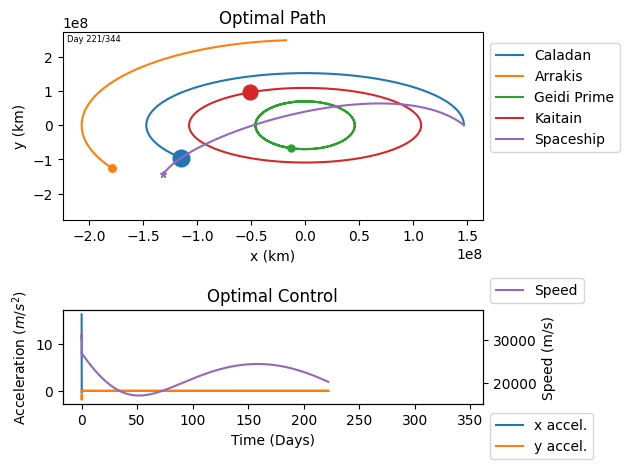

In [ ]:
animate(
    *best_path_tf(
        inner_planets_no_sun,
        1,
        np.ones((8, 10000))*10000,
        max_nodes=30000,
        N_COMPUTE_STEPS=10000,
        G=-6.674e-11,
    ),
    inner_planets_no_sun,
    figname="f5.png",
    animname="f5.mp4",
    # fig_suptitle="Figure 5: Free-time Initial Guess B"
)

In [ ]:
animate(
    *best_path_tf(
        inner_planets_no_sun,
        1.5,
        np.ones((8, 10000))*10000,
        max_nodes=30000,
        N_COMPUTE_STEPS=10000,
        G=-6.674e-11,
    ),
    inner_planets_no_sun,
    figname="f6.png",
    animname="f6.mp4",
    # fig_suptitle="Figure 6: Free-time Initial Guess C"
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.54e+03       1.22e+10         10000          19998     
       2          2.58e+02       1.82e+02         29998         (59994)    
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 2.58e+02 
Maximum boundary residual: 1.82e+02
45023863.186237566


/tmp/ipykernel_16604/2857342976.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to f6.png
Saving animation...
Animation saved to f6.mp4


In [24]:
# ----- Free-start-time Best Path -------

YEAR_TO_SEC = 31536000

def best_path_t0(
    planets: List[Planet],
    p0: float,
    y_guess: np.ndarray,
    T: float,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        t0 = p[0]
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t*t0), planet.py(t*t0))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t*t0)
            dy = sy - planet.py(t*t0)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return t0*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    # target_start_x = planets[0].px(T) + planets[0].radius
    # target_start_y = planets[0].py(T)
    target_end_x = planets[1].px(T*YEAR_TO_SEC)+ planets[1].radius
    target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    # velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        t0 = p[0]
        sx, sy = ya[0], ya[1]
        dsx, dsy = ya[2], ya[3]
        p1, p2, p3, p4 = ya[4], ya[5], ya[6], ya[7]
        ddsx = 0
        ddsy = 0
        for planet in planets:
            dist = norm(sx, sy, planet.px(t0), planet.py(t0))
            dist3 = dist**3
            dx = sx - planet.px(t0)
            dy = sy - planet.py(t0)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2

        target_start_y = planets[0].py(t0)
        target_start_x = planets[0].px(t0)+ planets[0].radius
        velocity_start_x, velocity_start_y = planets[0].velocity_vector(t0)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])

    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([p0*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    t0 = soln.p[0]
    
    return soln, t0, t

In [27]:
best_path_t0(inner_planets_no_sun,0.001,np.ones((8, 10000))*10000,0.5)[1]

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.75e+03       6.64e+05         10000          19998     
       2          4.16e+03       8.48e+06         29998          59994     
       3          1.93e+03       1.18e+08         89992        (179982)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 1.93e+03 
Maximum boundary residual: 1.18e+08


647248.0909895392

In [21]:
647248 / YEAR_TO_SEC

0.02052409944190766

In [17]:
# #Test it with the planets class:
animate(
    *best_path_t0(
        inner_planets_no_sun,
        0.1,
        np.ones((8, 10000))*10000,
        0.5,

    ),
    inner_planets_no_sun,
    figname='t0.png',
    animname="t0.mp4",
    # fig_suptitle="Figure 2: Fixed-time Caladan to Arrakis"
)

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.43e+00       1.54e+06         10000          19998     
       2          1.70e+02       2.75e+06         29998          59994     
       3          2.32e+02       5.53e+07         89992        (179982)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 2.32e+02 
Maximum boundary residual: 5.53e+07
1855876.8093925333


/var/folders/9b/7hhd76216mg0g_995zr6rb_c0000gn/T/ipykernel_52212/1829232278.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to t0.png
Saving animation...
Animation saved to t0.mp4


In [ ]:
YEAR_TO_SEC = 31536000

def best_path_t0(
    planets: List[Planet],
    t0_guess: float,
    y_guess: np.ndarray,
    T: float,
    figname: str,# | None = None,
    animname: str ,#| None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]
    
    tf = T * YEAR_TO_SEC
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        t0 = p[0]
        t_hat = t0 + (tf-t0)*t
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            px_t = planet.px(t_hat)
            py_t = planet.py(t_hat)
            dist = np.linalg.norm(np.array([sx-px_t, sy - py_t]))
            
            dist3 = np.exp(3*np.log(dist))
            dist5 = np.exp(5*np.log(dist))
            dx = sx - planet.px(t_hat)
            dy = sy - planet.py(t_hat)
            
            # Do these operations in log space for numerical stability.
            ddsx += dx*np.exp(np.log(planet.mass) - np.log(dist3))
            ddsy += dy*np.exp(np.log(planet.mass) - np.log(dist3))

            dp1 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dx**2*np.exp(np.log(planet.mass) - np.log(dist5))
            dp2 += np.exp(np.log(planet.mass) - np.log(dist3)) - 3*dy**2*np.exp(np.log(planet.mass) - np.log(dist5))

        ddsx = -G * ddsx + p3/2
        ddsy = -G * ddsy + p4/2
        
        dp1 = p3*G*dp1
        dp2 = p4*G*dp2
        
        dp3 = -p1 
        dp4 = -p2 

        return (tf-t0)*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    # target_start_x = planets[0].px(0) + planets[0].radius
    # target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(tf)+ planets[1].radius
    target_end_y = planets[1].py(tf)
    #Velocity BCs
    # velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        t0 = p[0]
        sx, sy = ya[0], ya[1]
        dsx, dsy = ya[2], ya[3]
        p1, p2, p3, p4 = ya[4], ya[5], ya[6], ya[7]

        ddsx = 0
        ddsy = 0

        for planet in planets:
            dist = np.linalg.norm(np.array([sx - planet.px(t0), sy - planet.py(t0)]))
            dist3 = np.exp(3*np.log(dist))
            dx = sx - planet.px(t0)
            dy = sy - planet.py(t0)
            
            # Do these operations in log space for numerical stability.
            ddsx += dx*np.exp(np.log(planet.mass) - np.log(dist3))
            ddsy += dy*np.exp(np.log(planet.mass) - np.log(dist3))

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2
 
        target_start_y = planets[0].py(t0)
        target_start_x = planets[0].px(t0) + planets[0].radius
        velocity_start_x, velocity_start_y = planets[0].velocity_vector(t0)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])
    
    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([t0_guess*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    t0 = soln.p[0]
    # tf = soln.p[1]
     
    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []
    
    tp = t0 + t*(tf - t0)
    
    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(tp)
        pyt = planet.py(tp)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(tp, ux, label='control in x direction')
    control_y_graph, = ax2.plot(tp, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()

    return t0/YEAR_TO_SEC, t, soln
    
    